In [ ]:
!pip install adversarial-robustness-toolbox
!pip install timm
!pip install pytorch-lightning
# !git clone https://github.com/chengyangfu/pytorch-vgg-cifar10.git
# !git clone https://github.com/nateraw/huggingface-vit-finetune.git
# !pip install --upgrade matplotlib
# !pip install matplotlib==3.1.3

     |████████████████████████████████| 839kB 13.7MB/s 
     |████████████████████████████████| 112kB 52.5MB/s 
     |████████████████████████████████| 276kB 52.7MB/s 
     |████████████████████████████████| 184kB 48.2MB/s 
     |████████████████████████████████| 829kB 52.8MB/s 
     |████████████████████████████████| 1.3MB 60.1MB/s 
     |████████████████████████████████| 143kB 66.9MB/s 
     |████████████████████████████████| 296kB 65.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=a3807780d20278486c2803a7b468a5df362b0e78ef3f9008ecb08aefa7a55d9b
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=0ef1d29b7d0df728fb79ce8af4a19495eba2f3b572b494e2d9ecd320c8abae92
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAM

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import art
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Files already downloaded and verified


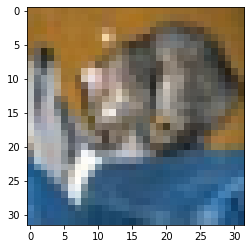

In [ ]:
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_testset_ut = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(cifar_testset_ut, batch_size=1)
# cifar_test_x = next(iter(test_loader))[0].numpy()
# cifar_test_x[0].shape

# for i, data in enumerate(test_loader, 0):
#   inputs, labels = data
# cifar_testset_ut[0][0]
plt.imshow(cifar_testset_ut[0][0]) 

# plt.imshow(np.transpose(cifar_test_x[0], (1, 2, 0))) 
# plt.imshow(np.transpose(test_loader[0], (1, 2, 0))) 


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=64,
                                         shuffle=False, num_workers=2)

cifar_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(cifar_trainloader)
print(cifar_trainset[0][0].shape)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


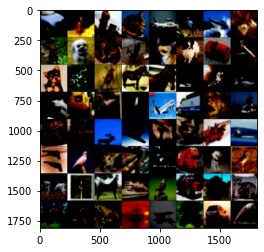

  car  deer truck   cat


In [ ]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % cifar_classes[labels[j]] for j in range(4)))

In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
# model.load_state_dict(torch.load("./pre_vit16_224_cifar10_30ep"))
model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 0.001 > 0.005 > 0.0003
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


TypeError: ignored

In [ ]:
model = nn.Sequential(
    model,
    nn.Linear
)

In [ ]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=4, precision=16, limit_train_batches=5)
trainer.fit(model, cifar_trainloader, cifar_testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


AttributeError: ignored

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(cifar_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 350 == 349:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   350] loss: 0.00018
[1,   700] loss: 0.00004
Finished Training


In [ ]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in cifar_testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on %d cifar-10 test images: %d %%' % (
    total,
    100 * correct / total))

Accuracy of the network on 10000 cifar-10 test images: 92 %


In [ ]:
torch.save(model.state_dict(), "./pre_vit16_224_cifar10_30Pep")

Start Prep Attacking

In [ ]:
# USE art
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = art.utils.load_dataset("cifar10") 

In [ ]:
from torch.utils.data import DataLoader
# train_loader = DataLoader(cifar_trainset, batch_size=len(cifar_trainset))
# cifar_train_x = next(iter(train_loader))[0].numpy()
# cifar_train_x[0].shape

In [ ]:
test_loader = DataLoader(cifar_testset, batch_size=len(cifar_testset))
cifar_test_x = next(iter(test_loader))[0].numpy()
cifar_test_x[0].shape

(3, 224, 224)

In [ ]:
cifar_test_y = next(iter(test_loader))[1].numpy()
cifar_test_y[0:3]

array([3, 8, 8])

In [ ]:
classifier = PyTorchClassifier(
    model=model,
    # clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=10,
)

# set up PGD-20 attack
eps = 0.03
attack = ProjectedGradientDescentPyTorch(
        estimator=classifier,
        norm="inf",
        eps=eps,
        targeted=False,
        eps_step=0.05,
        max_iter=20
)

NameError: ignored

In [ ]:
test_x_adv_1 = attack.generate(x=cifar_test_x[0:1000]) # takes around 7GB GPU

/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:670: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grad = torch.tensor(x).to(self._device)
/usr/local/lib/python3.7/dist-packages/art/estimators/classification/pytorch.py:671: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_grad = torch.tensor(y).to(self._device)


In [ ]:
predictions = classifier.predict(test_x_adv_1)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(cifar_test_y[0:1000])) / len(cifar_test_y[0:1000])
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

AxisError: ignored

In [ ]:
predictions[10]

array([-9.274439 , -5.673433 , -2.695107 ,  3.0447564, 22.388397 ,
        3.870098 , -3.0332572, -6.178993 , -7.170687 , -5.8633494],
      dtype=float32)

In [ ]:
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(cifar_test_y[0:1000])) / len(cifar_test_y[0:1000])
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 0.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted as dog, actual: cat')

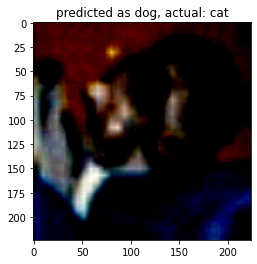

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[0], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[0])] + \
      ", actual: " + cifar_classes[cifar_test_y[0]]
plt.title(title_str)

In [ ]:
plt.imshow(np.transpose(cifar_test_x[0], (1, 2, 0))) 

NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted as deer, actual: plane')

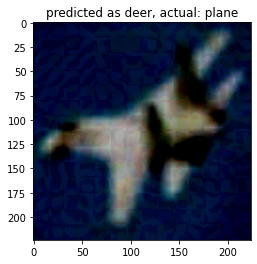

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[10], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[10])] + \
      ", actual: " + cifar_classes[cifar_test_y[10]]
plt.title(title_str)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted as dog, actual: horse')

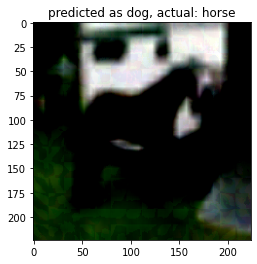

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[20], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[20])] + \
      ", actual: " + cifar_classes[cifar_test_y[20]]
plt.title(title_str)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'predicted as plane, actual: truck')

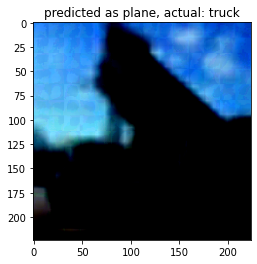

In [ ]:
plt.imshow(np.transpose(test_x_adv_1[50], (1, 2, 0))) 
title_str =  "predicted as " + cifar_classes[np.argmax(predictions[50])] + \
      ", actual: " + cifar_classes[cifar_test_y[50]]
plt.title(title_str)